# Predict With Random Forest and XGBoost

In [ ]:
# Membuat folder .kaggle di dalam folder root
!rm -rf ~/.kaggle && mkdir ~/.kaggle/

# Menyalin berkas kaggle.json pada direktori aktif saat ini ke folder .kaggle
!mv kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Mengunduh dataset menggunakan Kaggle CLI
!kaggle datasets download -d galaxyh/kdd-cup-1999-data

kdd-cup-1999-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip "/content/kdd-cup-1999-data.zip"

Archive:  /content/kdd-cup-1999-data.zip
replace corrected.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: corrected.gz            
  inflating: corrected/corrected     
  inflating: kddcup.data.corrected   
  inflating: kddcup.data.gz          
  inflating: kddcup.data/kddcup.data  
  inflating: kddcup.data_10_percent.gz  
  inflating: kddcup.data_10_percent/kddcup.data_10_percent  
  inflating: kddcup.data_10_percent_corrected  
  inflating: kddcup.names            
  inflating: kddcup.newtestdata_10_percent_unlabeled.gz  
  inflating: kddcup.newtestdata_10_percent_unlabeled/kddcup.newtestdata_10_percent_unlabeled  
  inflating: kddcup.testdata.unlabeled.gz  
  inflating: kddcup.testdata.unlabeled/kddcup.testdata.unlabeled  
  inflating: kddcup.testdata.unlabeled_10_percent.gz  
  inflating: kddcup.testdata.unlabeled_10_percent/kddcup.testdata.unlabeled_10_percent  
  inflating: training_attack_types   
  inflating: typo-correction.txt     


# Instalasi Library Yang Dibutuhkan

In [ ]:
!pip install sklearn
!pip install xgboost
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import Library Yang Dibutuhkan

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt 
#from sklearn_evaluation import plot
import numpy as np 
import os 
import pandas as pd 
import joblib
from sklearn.model_selection import train_test_split,GridSearchCV


from sklearn import preprocessing
from matplotlib.pyplot import plot


%matplotlib inline

In [ ]:
# Histogram distribusi
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 70]]
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (8 * nGraphPerRow, 10 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [ ]:
# Confusion matriks

def plotCorrelationMatrix(df, graphWidth, dataframeName):
    filename = dataframeName#df.dataframeName
    df = df.dropna('columns') #Bulatkan kolom dengan nilai NaN
    df = df[[col for col in df if df[col].nunique() > 1]] #Pertahankan kolom dengan lebih dari satu nilai unik
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

# deskripsi data

In [ ]:
# 42 karakteristik pencatatan data

cols = """
    duration,
protocol_type,
service,
flag,
src_bytes,
dst_bytes,
land,
wrong_fragment,
urgent,
hot,
num_failed_logins,
logged_in,
num_compromised,
root_shell,
su_attempted,
num_root,
num_file_creations,
num_shells,
num_access_files,
num_outbound_cmds,
is_host_login,
is_guest_login,
count,
srv_count,
serror_rate,
srv_serror_rate,
rerror_rate,
srv_rerror_rate,
same_srv_rate,
diff_srv_rate,
srv_diff_host_rate,
dst_host_count,
dst_host_srv_count,
dst_host_same_srv_rate,
dst_host_diff_srv_rate,
dst_host_same_src_port_rate,
dst_host_srv_diff_host_rate,
dst_host_serror_rate,
dst_host_srv_serror_rate,
dst_host_rerror_rate,
dst_host_srv_rerror_rate"""
cols = [c.strip() for c in cols.split(",") if c.strip()]
cols.append('target')

In [ ]:
# Jenis serangan yang sesuai dengan tag

attacks_type = {
'normal': 'normal',
'back': 'dos',
'buffer_overflow': 'u2r',
'ftp_write': 'r2l',
'guess_passwd': 'r2l',
'imap': 'r2l',
'ipsweep': 'probe',
'land': 'dos',
'loadmodule': 'u2r',
'multihop': 'r2l',
'neptune': 'dos',
'nmap': 'probe',
'perl': 'u2r',
'phf': 'r2l',
'pod': 'dos',
'portsweep': 'probe',
'rootkit': 'u2r',
'satan': 'probe',
'smurf': 'dos',
'spy': 'r2l',
'teardrop': 'dos',
'warezclient': 'r2l',
'warezmaster': 'r2l',
    }

In [ ]:
# membaca data
df = pd.read_csv("/content/kddcup.data_10_percent/kddcup.data_10_percent", names=cols) 
df['Attack'] = df.target.apply(lambda r: attacks_type[r[:-1]])
print("The data shape is (lines, columns):",df.shape)
df.head(10)

The data shape is (lines, columns): (494021, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target,Attack
0,0,tcp,http,SF,181,5450,0,0,0,0,...,1.0,0.0,0.11,0.00,0.0,0.0,0.0,0.0,normal.,normal
1,0,tcp,http,SF,239,486,0,0,0,0,...,1.0,0.0,0.05,0.00,0.0,0.0,0.0,0.0,normal.,normal
2,0,tcp,http,SF,235,1337,0,0,0,0,...,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,normal.,normal
3,0,tcp,http,SF,219,1337,0,0,0,0,...,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,normal.,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,normal.,normal
5,0,tcp,http,SF,217,2032,0,0,0,0,...,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,normal.,normal
6,0,tcp,http,SF,212,1940,0,0,0,0,...,1.0,0.0,1.00,0.04,0.0,0.0,0.0,0.0,normal.,normal
7,0,tcp,http,SF,159,4087,0,0,0,0,...,1.0,0.0,0.09,0.04,0.0,0.0,0.0,0.0,normal.,normal
8,0,tcp,http,SF,210,151,0,0,0,0,...,1.0,0.0,0.12,0.04,0.0,0.0,0.0,0.0,normal.,normal
9,0,tcp,http,SF,212,786,0,0,0,1,...,1.0,0.0,0.12,0.05,0.0,0.0,0.0,0.0,normal.,normal


In [ ]:
# ganti nama

hajar_to_cup = {
    'is_hot_login' : 'is_host_login',
'urg' : 'urgent',
'protocol' : 'protocol_type',
'count_sec' : 'count',
'srv_count_sec' : 'srv_count',
'serror_rate_sec' : 'serror_rate',
'srv_serror_rate_sec' : 'srv_serror_rate',
'rerror_rate_sec' : 'rerror_rate',
'srv_error_rate_sec' : 'srv_rerror_rate',
'same_srv_rate_sec' : 'same_srv_rate',
'diff_srv_rate_sec' : 'diff_srv_rate',
'srv_diff_host_rate_sec' : 'srv_diff_host_rate',
'count_100' : 'dst_host_count',
'srv_count_100' : 'dst_host_srv_count',
'same_srv_rate_100' : 'dst_host_same_srv_rate',
'diff_srv_rate_100' : 'dst_host_diff_srv_rate',
'same_src_port_rate_100' : 'dst_host_same_src_port_rate',
'srv_diff_host_rate_100' : 'dst_host_srv_diff_host_rate',
'serror_rate_100' : 'dst_host_serror_rate',
'srv_serror_rate_100' : 'dst_host_srv_serror_rate',
'rerror_rate_100' : 'dst_host_rerror_rate',
'srv_rerror_rate_100' : 'dst_host_srv_rerror_rate',
}

In [ ]:
#Statistik jumlah catatan dari berbagai jenis serangan
df.Attack.value_counts()

dos       391458
normal     97278
probe       4107
r2l         1126
u2r           52
Name: Attack, dtype: int64

In [ ]:
#tag, jenis serangan
df.target.unique(), df.Attack.unique()

(array(['normal.', 'buffer_overflow.', 'loadmodule.', 'perl.', 'neptune.',
        'smurf.', 'guess_passwd.', 'pod.', 'teardrop.', 'portsweep.',
        'ipsweep.', 'land.', 'ftp_write.', 'back.', 'imap.', 'satan.',
        'phf.', 'nmap.', 'multihop.', 'warezmaster.', 'warezclient.',
        'spy.', 'rootkit.'], dtype=object),
 array(['normal', 'u2r', 'dos', 'r2l', 'probe'], dtype=object))

# Distribusi Data: Distribusi Fitur Kategoris

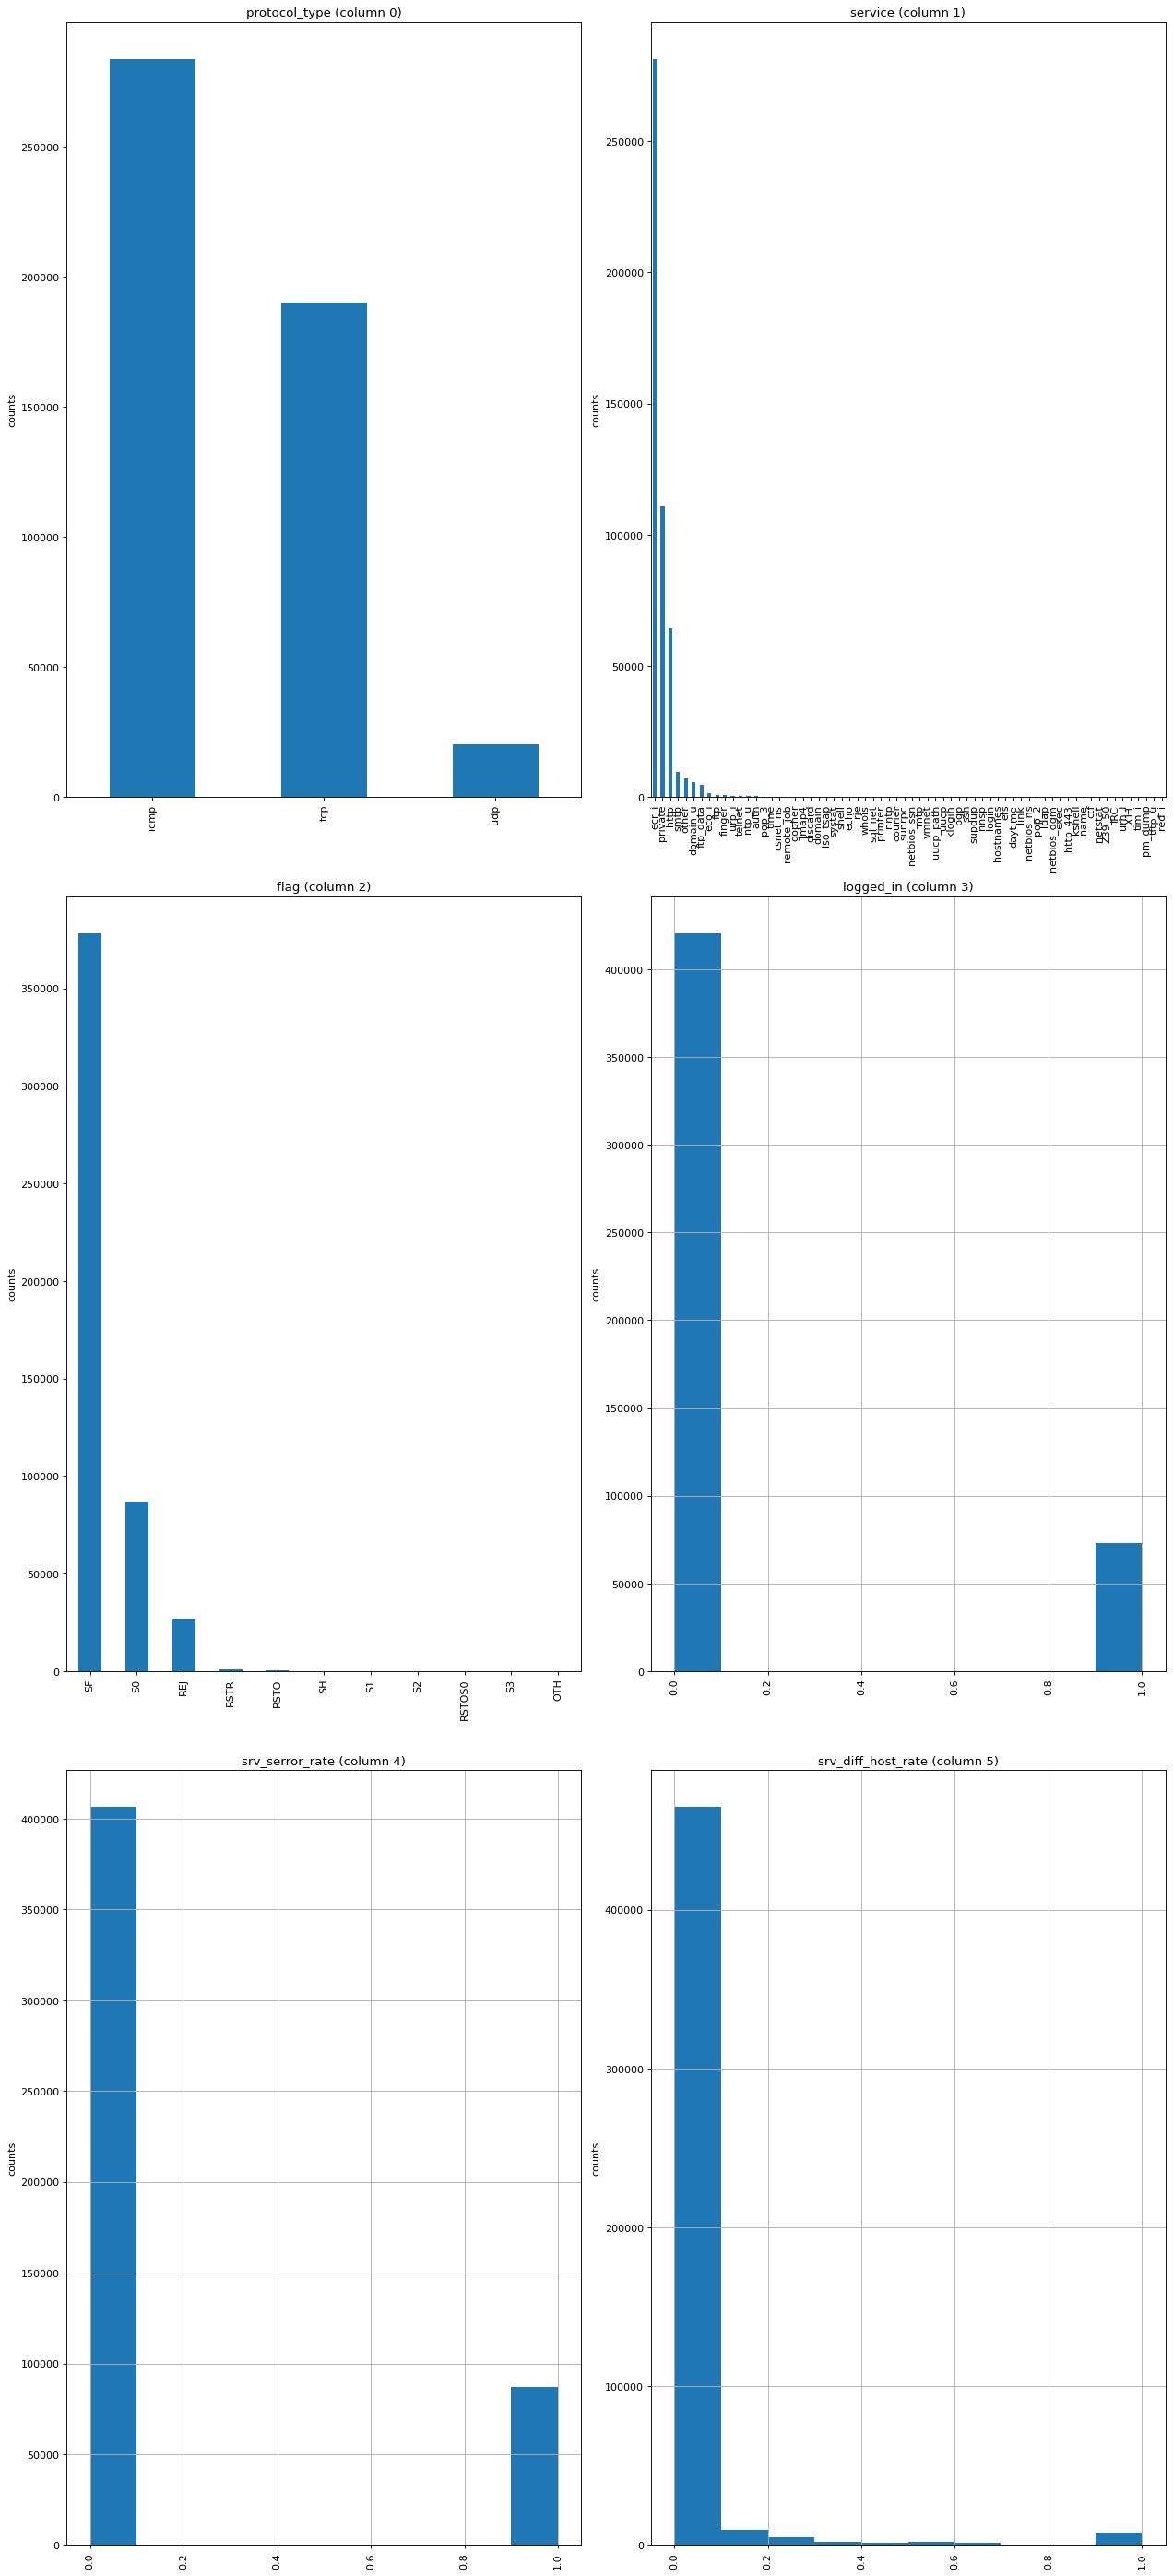

In [ ]:
plotPerColumnDistribution(df[[
    'protocol_type',
    'service',
    'flag',
    'logged_in',
    'srv_serror_rate',
    'srv_diff_host_rate',
]], nGraphShown=30, nGraphPerRow=2)

# Asosiasi Data: Asosiasi Fitur Numerik

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  """


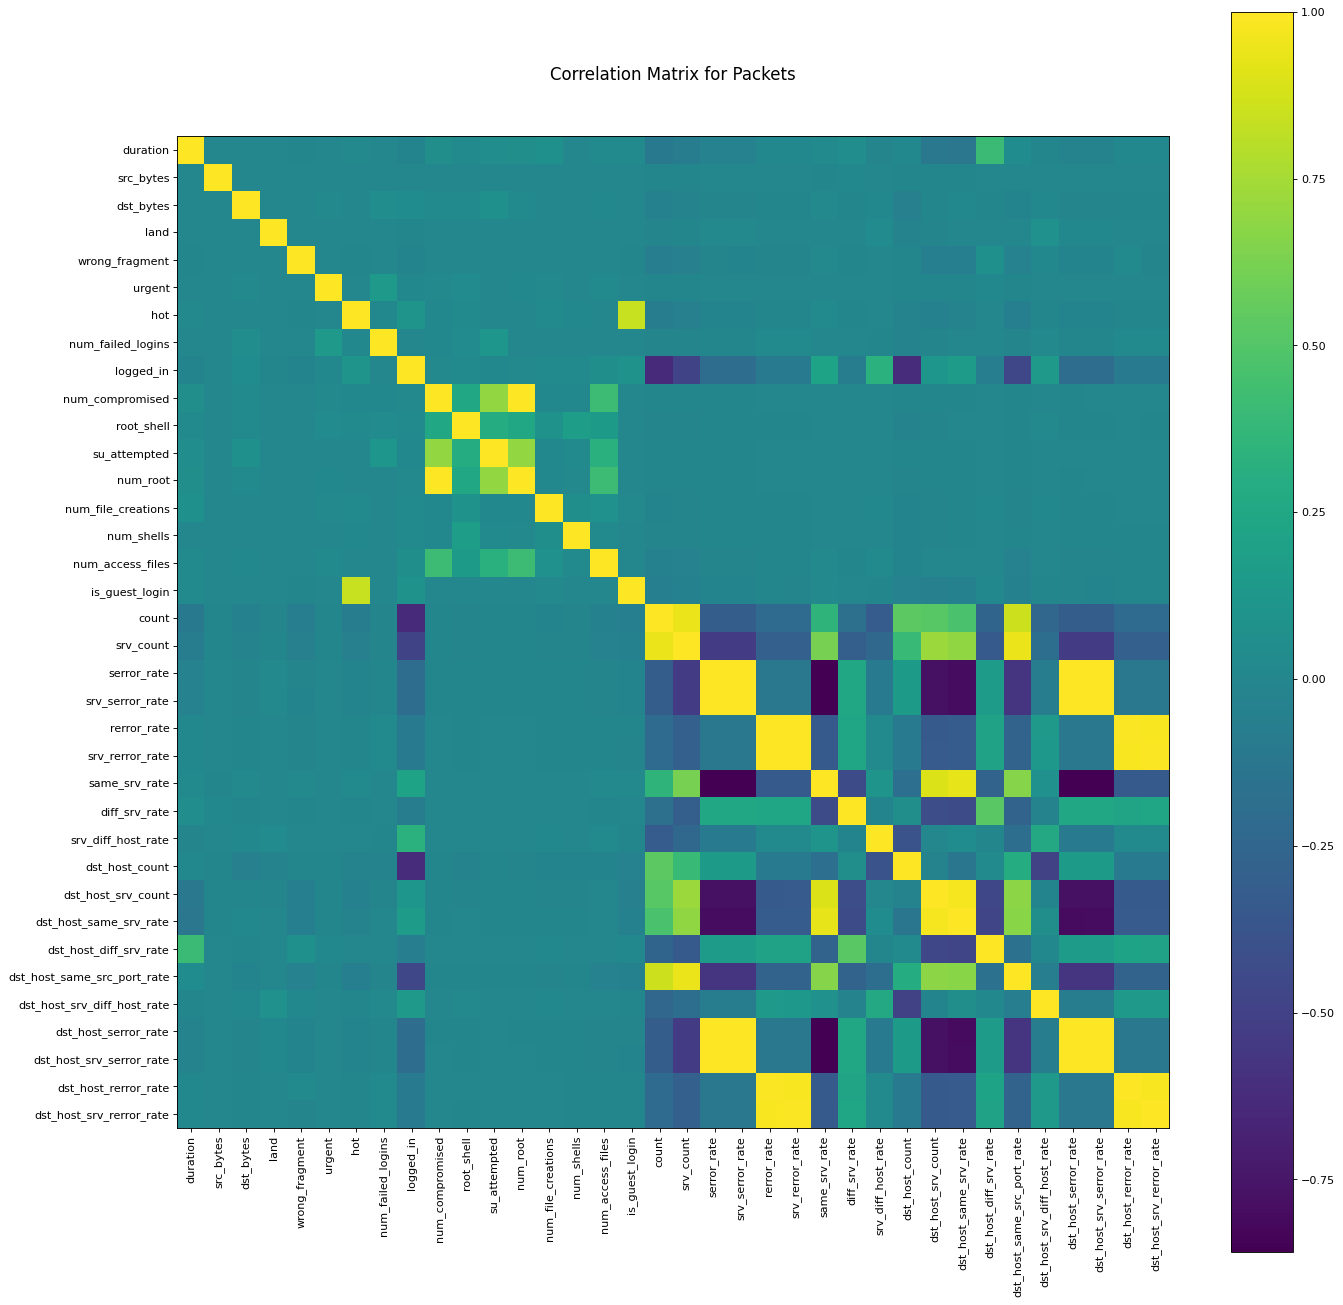

In [ ]:
plotCorrelationMatrix(df, graphWidth=20, dataframeName="Packets")

# pra-pemrosesan data

In [ ]:
#Periksa nilai yang hilang
for c in df.columns:
    print("%30s : %d"%(c, sum(pd.isnull(df[c]))))

                      duration : 0
                 protocol_type : 0
                       service : 0
                          flag : 0
                     src_bytes : 0
                     dst_bytes : 0
                          land : 0
                wrong_fragment : 0
                        urgent : 0
                           hot : 0
             num_failed_logins : 0
                     logged_in : 0
               num_compromised : 0
                    root_shell : 0
                  su_attempted : 0
                      num_root : 0
            num_file_creations : 0
                    num_shells : 0
              num_access_files : 0
             num_outbound_cmds : 0
                 is_host_login : 0
                is_guest_login : 0
                         count : 0
                     srv_count : 0
                   serror_rate : 0
               srv_serror_rate : 0
                   rerror_rate : 0
               srv_rerror_rate : 0
                 sam

# Penandaan/Pengkodean Data
Pilih fitur (berdasarkan varians, korelasi)

perbedaan:

Variansnya adalah 0, yang menunjukkan bahwa fitur tersebut sama untuk semua record, dan fitur yang paling ideal harus memiliki varians yang lebih besar, yang menunjukkan bahwa tipe record yang berbeda menunjukkan perbedaan dalam fitur ini. Jadi hapus fitur dengan 0 varians.

In [ ]:
df_std = df.std() #varians semua fitur
df_std = df_std.sort_values(ascending=True) #sort keluaran
df_std

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


is_host_login                       0.000000
num_outbound_cmds                   0.000000
urgent                              0.005510
land                                0.006673
su_attempted                        0.007793
root_shell                          0.010551
num_shells                          0.011020
num_failed_logins                   0.015520
num_access_files                    0.036482
is_guest_login                      0.037211
dst_host_srv_diff_host_rate         0.042133
diff_srv_rate                       0.082205
num_file_creations                  0.096416
dst_host_diff_srv_rate              0.109259
wrong_fragment                      0.134805
srv_diff_host_rate                  0.142397
dst_host_srv_rerror_rate            0.230140
dst_host_rerror_rate                0.230590
rerror_rate                         0.231623
srv_rerror_rate                     0.232147
logged_in                           0.355345
dst_host_serror_rate                0.380593
serror_rat

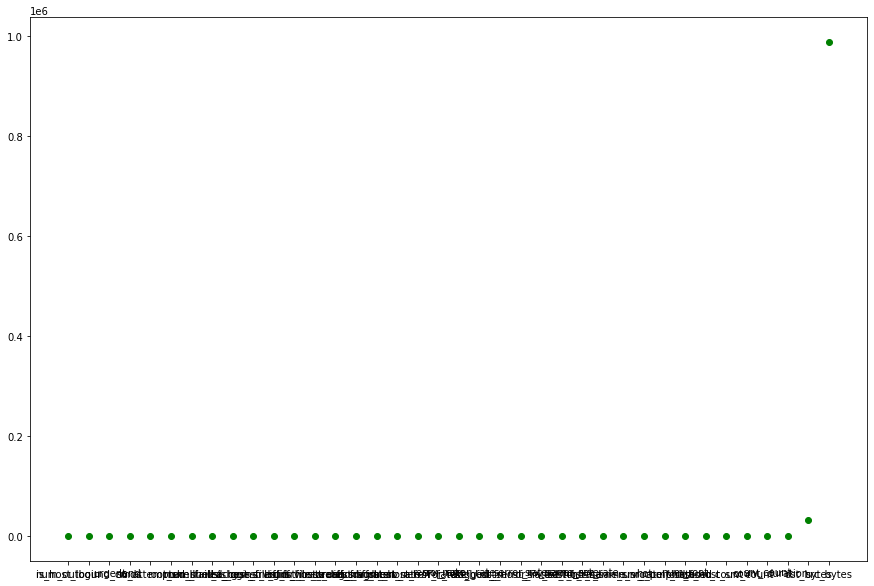

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(list(df_std.index) ,list(df_std.values), 'go')

plt.show()

Korelasi:

Beberapa fitur yang berkorelasi sempurna dapat dihilangkan. Karena (srv_serror_rate, serror_rate) terkait dengan (dst_host_srv_count, dst_host_count), maka dalam kasus ini, srv_rate dan dst_host_count dapat dihilangkan.

In [ ]:
#Amati matriks korelasi melalui plotScatterMatrix terlebih dahulu
def standardize_columns(df, cols_map=hajar_to_cup):
    #Hapus kolom 'layanan'; ganti nama jika kolom TCPPDUMP ada
    if 'service' in df.columns:
        df = df.drop(['service'], axis = 1)
    df.rename(columns = cols_map)
    return df

df = standardize_columns(df, cols_map=hajar_to_cup)

# Bagilah data menjadi set pelatihan dan pengujian

In [ ]:
df = df.drop(['target',], axis=1)
print(df.shape)
#41 item sebelumnya digunakan sebagai input X, dan kolom Attack digunakan sebagai label deteksi y
y = df.Attack
X = df.drop(['Attack',], axis=1)
#Hasilkan set pelatihan dan set tes secara acak
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(494021, 41)
(330994, 40) (163027, 40)
(330994,) (163027,)


In [ ]:
le_X_cols = {}
le_y = preprocessing.LabelEncoder()

for c in X_train.columns:
    if str(X_train[c].dtype) == 'object': 
        le_X = preprocessing.LabelEncoder()
        X_train[c] = le_X.fit_transform(X_train[c])
        X_test[c] = le_X.transform(X_test[c])
        le_X_cols[c] = le_X

y_train = le_y.fit_transform(y_train.values)
y_test = le_y.transform(y_test.values)

#simpan label
joblib.dump(le_X_cols, 'le_X_cols.pkl') 
joblib.dump(le_y, 'le_y.pkl') 


['le_y.pkl']

In [ ]:
class_names, class_index = le_y.classes_, np.unique(y_train)
class_names, class_index

(array(['dos', 'normal', 'probe', 'r2l', 'u2r'], dtype=object),
 array([0, 1, 2, 3, 4]))

In [ ]:
#penskalaan fitur
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
X_train[['dst_bytes','src_bytes']] = scaler.fit_transform(X_train[['dst_bytes','src_bytes']])
X_test[['dst_bytes','src_bytes']] = scaler.transform(X_test[['dst_bytes','src_bytes']])
#menyimpan
joblib.dump(scaler, 'scaler_1.pkl')

['scaler_1.pkl']

# Dua Model Partisi (Random Forest dan XGBoost)

1- Model Klasifikasi Hutan Acak

In [ ]:
from sklearn.ensemble import RandomForestClassifier
#Model dasar tanpa penyetelan parameter dan pemilihan fitur
classifier = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)
print("akurasi pelatihan:", classifier.score(X_train, y_train))
print("akurasi tes:",classifier.score(X_test,y_test))
diff_base = abs(classifier.score(X_train, y_train) - classifier.score(X_test,y_test))
print("Over/underfitting dari model：", diff_base)

akurasi pelatihan: 0.9999939575943975
akurasi tes: 0.9997301060560521
Over/underfitting dari model： 0.0002638515383454054


In [ ]:
#Prediksi data dalam set tes
y_pred = classifier.predict(X_test)

reversefactor = dict(zip(class_index,class_names))
y_test_rev = np.vectorize(reversefactor.get)(y_test)
y_pred_rev = np.vectorize(reversefactor.get)(y_pred)
#menghasilkan confusion matriks
print(pd.crosstab(y_test_rev, y_pred_rev, rownames=['Actual packets attacks'], colnames=['Predicted packets attcks']))


Predicted packets attcks     dos  normal  probe  r2l  u2r
Actual packets attacks                                   
dos                       129106       0      0    0    0
normal                         0   32160      4    3    0
probe                          0      15   1333    0    0
r2l                            0      14      0  373    0
u2r                            0       8      0    0   11


## 1-1 Pilihan fitur

In [ ]:
clf = RandomForestClassifier(n_estimators=30)
clf = clf.fit(X_train, y_train)
fti = clf.feature_importances_
model = SelectFromModel(clf, prefit=True, threshold= 0.005)
X_train_new = model.transform(X_train)
X_test_new = model.transform(X_test)
selcted_features = X_train.columns[model.get_support()]
print(X_train_new.shape)

(330994, 22)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
#fitur pilihan
selcted_features

Index(['protocol_type', 'flag', 'src_bytes', 'dst_bytes', 'logged_in',
       'num_compromised', 'count', 'srv_count', 'rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate'],
      dtype='object')

## 1-2 Penyesuaian parameter

In [ ]:
parameters = {
    'n_estimators'      : [20,40,128,130],
    'max_depth'         : [None,14, 15, 17],
    'criterion' :['gini','entropy'],
    'random_state'      : [42],
    
}
clf = GridSearchCV(RandomForestClassifier(), parameters, cv=2, n_jobs=-1, verbose=5)
clf.fit(X_train_new, y_train)

Fitting 2 folds for each of 32 candidates, totalling 64 fits


GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 14, 15, 17],
                         'n_estimators': [20, 40, 128, 130],
                         'random_state': [42]},
             verbose=5)

In [ ]:
print("clf.best_estimator_:",clf.best_estimator_)
print("clf.best_params_",clf.best_params_)

clf.best_estimator_: RandomForestClassifier(criterion='entropy', max_depth=17, n_estimators=40,
                       random_state=42)
clf.best_params_ {'criterion': 'entropy', 'max_depth': 17, 'n_estimators': 40, 'random_state': 42}


In [ ]:
print("Akurasi pelatihan CV：",clf.best_score_)
print("Akurasi tes CV：",clf.score(X_test_new,y_test))
diff_fst = abs(clf.best_score_ - clf.score(X_test_new,y_test))
print("akurasi buruk：", diff_fst)
print("Peningkatan kinerja model?", diff_base > diff_fst)

Akurasi pelatihan CV： 0.9996314132582463
Akurasi tes CV： 0.9997485079158667
akurasi buruk： 0.00011709465762033133
Peningkatan kinerja model? True


In [ ]:
# confusion matriks
#prediksi kumpulan data pengujian
y_pred = clf.predict(X_test_new)

reversefactor = dict(zip(class_index,class_names))
y_test_rev = np.vectorize(reversefactor.get)(y_test)
y_pred_rev = np.vectorize(reversefactor.get)(y_pred)
#menghasilkan confusion matriks
print(pd.crosstab(y_test_rev, y_pred_rev, rownames=['Actual packets attacks'], colnames=['Predicted packets attcks']))

Predicted packets attcks     dos  normal  probe  r2l  u2r
Actual packets attacks                                   
dos                       129106       0      0    0    0
normal                         2   32160      2    3    0
probe                          1       9   1338    0    0
r2l                            0      15      0  372    0
u2r                            0       8      0    1   10


# simpan model

In [ ]:
joblib.dump(clf, 'random_forest_classifier.pkl') 

['random_forest_classifier.pkl']

# 2- Model XGBoost

2-1 Model Dasar

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
clf = OneVsRestClassifier(XGBClassifier(n_jobs=-1, max_depth=4, n_estimators=70, random_state=42,verbosity=1))

#Encode variabel dalam array [[x, y, z]] sebagai multilabel melalui MultiLabelBinarizer
lb = preprocessing.LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)
lb.fit(y_train)
y_train_xgb = lb.transform(y_train)
y_test_xgb = lb.transform(y_test)
#model train
clf.fit(X_train[selcted_features], y_train_xgb)

OneVsRestClassifier(estimator=XGBClassifier(max_depth=4, n_estimators=70,
                                            n_jobs=-1, random_state=42))

In [ ]:
#predict
y_pred_xgb = clf.predict(X_test[selcted_features])

print("akurasi pelatihan：", clf.score(X_train[selcted_features], y_train_xgb))
print("akurasi tes：",clf.score(X_test[selcted_features],y_test_xgb))# New data, not included in Training data
diff_xgb = abs(clf.score(X_train[selcted_features], y_train_xgb) - clf.score(X_test[selcted_features],y_test_xgb))
print("akurasi buruk：", diff_xgb)

akurasi pelatihan： 0.9989335154111555
akurasi tes： 0.9987916112055059
akurasi buruk： 0.00014190420564963446


In [ ]:
# confusion matriks
y_pred_xgb = np.argmax(y_pred_xgb, axis=1)

reversefactor = dict(zip(class_index,class_names))
y_test_rev = np.vectorize(reversefactor.get)(y_test)
y_pred_rev = np.vectorize(reversefactor.get)(y_pred_xgb)
# menghasilkan confusion matriks
print(pd.crosstab(y_test_rev, y_pred_rev, rownames=['Actual packets attacks'], colnames=['Predicted packets attcks']))

Predicted packets attcks     dos  normal  probe  r2l  u2r
Actual packets attacks                                   
dos                       129104       2      0    0    0
normal                        23   32140      0    4    0
probe                         16      11   1321    0    0
r2l                            7      75      0  305    0
u2r                            2      16      0    0    1


## 2-2 Penyesuaian parameter

In [ ]:
import xgboost as xgb
print(X_train.shape)

xgb_model = OneVsRestClassifier(XGBClassifier(n_jobs=-1, max_depth=4, n_estimators=70, random_state=42,verbosity=1))

parameters = {'estimator__nthread':[4,], # sesuaikan utas
              'estimator__objective':['binary:logistic',],
              'estimator__learning_rate': [0.1,0.08], #nilai 'eta'
              'estimator__max_depth': [4,6],
              'estimator__min_child_weight': [1,],
              'estimator__silent': [1,],
              'estimator__subsample': [1,],
              'estimator__colsample_bytree': [1,],
              'estimator__n_estimators': [70,100], #jumlah pohon keputusan
              'estimator__random_state':[42],
              }


clf = GridSearchCV(xgb_model, parameters, 
                   cv=2, n_jobs=-1, verbose=5, refit=True)
#Latih modelnya
clf.fit(X_train[selcted_features], y_train_xgb)

(330994, 40)
Fitting 2 folds for each of 8 candidates, totalling 16 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=2,
             estimator=OneVsRestClassifier(estimator=XGBClassifier(max_depth=4,
                                                                   n_estimators=70,
                                                                   n_jobs=-1,
                                                                   random_state=42)),
             n_jobs=-1,
             param_grid={'estimator__colsample_bytree': [1],
                         'estimator__learning_rate': [0.1, 0.08],
                         'estimator__max_depth': [4, 6],
                         'estimator__min_child_weight': [1],
                         'estimator__n_estimators': [70, 100],
                         'estimator__nthread': [4],
                         'estimator__objective': ['binary:logistic'],
                         'estimator__random_state': [42],
                         'estimator__silent': [1],
                         'estimator__subsample': [1]},
             verbose=5)

In [ ]:
print("Akurasi pelatihan CV：",clf.best_score_)
print("parameter：", clf.best_params_)
print("Akurasi tes CV：",clf.score(X_test[selcted_features],y_test_xgb))
diff_fst = abs(clf.best_score_ - clf.score(X_test[selcted_features],y_test_xgb))
print("akurasi buruk：", diff_fst)

Akurasi pelatihan CV： 0.9994380562789658
parameter： {'estimator__colsample_bytree': 1, 'estimator__learning_rate': 0.1, 'estimator__max_depth': 6, 'estimator__min_child_weight': 1, 'estimator__n_estimators': 100, 'estimator__nthread': 4, 'estimator__objective': 'binary:logistic', 'estimator__random_state': 42, 'estimator__silent': 1, 'estimator__subsample': 1}
Akurasi tes CV： 0.9995583553644488
akurasi buruk： 0.00012029908548305546


In [ ]:
#Confusion matriks untuk model XGB terbaik
y_pred_xgb = clf.predict(X_test[selcted_features])
y_pred_xgb = np.argmax(y_pred_xgb, axis=1)
reversefactor = dict(zip(class_index,class_names))
y_test_rev = np.vectorize(reversefactor.get)(y_test)
y_pred_rev = np.vectorize(reversefactor.get)(y_pred_xgb)
#hasil confusion matriks
print(pd.crosstab(y_test_rev, y_pred_rev, rownames=['Actual packets attacks'], colnames=['Predicted packets attcks']))


Predicted packets attcks     dos  normal  probe  r2l  u2r
Actual packets attacks                                   
dos                       129105       1      0    0    0
normal                        12   32149      4    2    0
probe                          2       9   1337    0    0
r2l                            6      19      0  362    0
u2r                            5       7      0    0    7


# simpan model

In [ ]:
joblib.dump(clf, 'xgboost_classifier.pkl') 

['xgboost_classifier.pkl']

# Merakit model
Bangun model dari dua model yang diterapkan di atas

In [ ]:
#Penggantian nama kolom yang sesuai
needed_cols_dump = []
for l in selcted_features:
    if l in hajar_to_cup.values():
        for k, v in hajar_to_cup.items():
            if v == l:
                needed_cols_dump.append(k)
    else:
        needed_cols_dump.append(l)
print(len(needed_cols_dump), len(selcted_features))
print(needed_cols_dump)

22 22
['protocol', 'flag', 'src_bytes', 'dst_bytes', 'logged_in', 'num_compromised', 'count_sec', 'srv_count_sec', 'rerror_rate_sec', 'same_srv_rate_sec', 'diff_srv_rate_sec', 'srv_diff_host_rate_sec', 'count_100', 'srv_count_100', 'same_srv_rate_100', 'diff_srv_rate_100', 'same_src_port_rate_100', 'srv_diff_host_rate_100', 'serror_rate_100', 'srv_serror_rate_100', 'rerror_rate_100', 'srv_rerror_rate_100']


In [ ]:
def do_what_we_want(X, 
                    scaler_1, 
                    le_X_cols, 
                    selcted_features, 
                    map_cols,
                    rdf_clf,
                    xgb_clf,
                    PathX=False):
    if PathX:
        X = pd.read_csv(PathX, names=cols, nrows=30000)
    X = standardize_columns(X, cols_map=map_cols) #ganti nama kolom
    X[['dst_bytes','src_bytes']] = scaler_1.fit_transform(X[['dst_bytes','src_bytes']])
    X = X[selcted_features]
    for c in X.columns:
        if str(X[c].dtype) == 'object': 
            le_X = le_X_cols[c]
            X[c] = le_X.transform(X[c])
            
    res = {
        'rd_prd_prb': rdf_clf.predict_proba(X),
        'rd_prd': rdf_clf.predict(X),
        'xgb_prd_prb': xgb_clf.predict_proba(X),
        'xgb_prd': xgb_clf.predict(X),
        
    }
    
    return res

In [ ]:
scaler_1 = joblib.load('/content/scaler_1.pkl') #data berskala
le_X_cols = joblib.load('/content/le_X_cols.pkl') #Label set pelatihan
le_y = joblib.load('/content/le_y.pkl') #Label set pengujian
xgb_clf = joblib.load('/content/xgboost_classifier.pkl') #XGBoost model
rdf_clf = joblib.load('/content/random_forest_classifier.pkl') #model hutan acak

In [ ]:
# membaca data
X = pd.read_csv("/content/kddcup.data_10_percent/kddcup.data_10_percent", names=cols, nrows=100000)
Y = X.target.apply(lambda r: attacks_type[r[:-1]])

res = do_what_we_want(X, 
                    scaler_1, 
                    le_X_cols, 
                    selcted_features, 
                    hajar_to_cup,
                    rdf_clf,
                    xgb_clf,
                    PathX=False)
res.keys()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


dict_keys(['rd_prd_prb', 'rd_prd', 'xgb_prd_prb', 'xgb_prd'])

#Agregat menggunakan Regresi Logistik untuk menumpuk prediksi

In [ ]:
atks = ['dos', 'normal', 'probe', 'r2l', 'u2r']
rd_prd_df = pd.DataFrame(data=res['rd_prd_prb'])
rd_prd_df= rd_prd_df.rename(columns = {l:'rd_'+atks[l] for l in range(len(atks))})
xg_prd_df = pd.DataFrame(data=res['xgb_prd_prb'])
xg_prd_df= xg_prd_df.rename(columns = {l:'xg_'+atks[l] for l in range(len(atks))})

df = pd.concat([rd_prd_df, xg_prd_df], axis=1)
df.head()

,rd_dos,rd_normal,rd_probe,rd_r2l,rd_u2r,xg_dos,xg_normal,xg_probe,xg_r2l,xg_u2r
0,0.100,0.725,0.000,0.075,0.100,0.000054,0.722444,0.000057,0.000045,0.005603
1,0.100,0.750,0.025,0.050,0.075,0.001795,0.770401,0.000071,0.000025,0.000025
2,0.075,0.750,0.025,0.050,0.100,0.000730,0.806240,0.000071,0.000025,0.000025
3,0.075,0.725,0.025,0.075,0.100,0.000730,0.836683,0.000065,0.000025,0.000025
4,0.050,0.775,0.000,0.050,0.125,0.000044,0.950191,0.000048,0.000025,0.000025


In [ ]:
params={"C":np.logspace(-7,7,7), "penalty":["l2"], "multi_class":['auto','ovr']}
lg = LogisticRegression(C=4.5, random_state = 42, multi_class = 'ovr', solver = 'lbfgs', max_iter = 1000)
clf = GridSearchCV(lg, params, cv=3)
clf.fit(df[:20000], Y[:20000])
print("akurasi pelatihan：", clf.score(df[:20000], Y[:20000]))
print("akurasi tes：",clf.score(df[20000:], Y[20000:]))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org

akurasi pelatihan： 0.99965
akurasi tes： 0.975675
